In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import cv2
import time
import matplotlib.pyplot as plt



In [2]:

# Data Loader
import sys
# sys.path.insert(0, '/Users/pauli/Documents/Studium/Master/3. Semester Auslandssemester DTU/Deep Learning/Final Project/Otovo/')
#from autotetris.dataloader import RoofDataSet
from dataloader import RoofDataSet
from dataloader import Transforms
from dataloader import show_centroids


In [3]:
# path = os.getcwd()
# path += '/small_sample_out/metadata_sample.hdf'
path = 'C:/Users/guzma/OneDrive/Documents/TEC/DTU/02456/Project/Github_Project/Dataset/data_2022-11-01/meta_data.hdf'
input_path = path
print(path)
df = pd.read_hdf(path, '/d')
# centroid=df.iloc[:,6].values
# test = df.building_id.str.split('-b15',n = 1, expand = True)[0].tolist()
centroid = np.array(df.panel_centroids.to_list())

C:/Users/guzma/OneDrive/Documents/TEC/DTU/02456/Project/Github_Project/Dataset/data_2022-11-01/meta_data.hdf


C:\Users\guzma\AppData\Local\Temp\ipykernel_19468\3739800701.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  centroid = np.array(df.panel_centroids.to_list())


In [4]:
dataset = RoofDataSet(path, transform=Transforms(new_size=(256,256)))

-------------------- Initializing dataset --------------------
--> Metadata read
--> Num_panels computed
--> Samples with many panels dropped
--> Padding samples
--> Dataset ready


Changes have to be made here to get the image path.

In [5]:
imp_path = dataset.image_paths +  "/"+dataset.id[0]+"-b15-otovowms.jpeg"

In [6]:
# image = cv2.imread('C:/Users/guzma/OneDrive/Documents/TEC/DTU/02456/Project/Github_Project/autotetris/small_sample_out/2d5c5e72-bf4a-4e02-8768-5dd987583398-b15-otovowms.jpeg')
image = cv2.imread(imp_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [7]:
len(dataset)

37138

In [8]:
# split the dataset into training, validation and test sets
# Create testset
len_test_set = int(0.1*len(dataset))
len_train_set = len(dataset) - len_test_set

train_dataset , test_dataset  = torch.utils.data.random_split(dataset, [len_train_set, len_test_set])


len_valid_set = int(0.1*len(train_dataset))
len_train_set = len(train_dataset) - len_valid_set

train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [len_train_set, len_valid_set])

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))
print("The length of Test set is {}".format(len_test_set))


# shuffle and batch the datasets
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

The length of Train set is 30083
The length of Valid set is 3342
The length of Test set is 3713


In [9]:
# Test sizes of tensors for adjusting Resnet input and output layer
#image, centroids = next(iter(train_loader))

#print("The size of image tensor set is {}".format(image.shape))
#print("The size of centroids tensor set is {}".format(centroids.shape))

In [10]:
# Test sizes of tensors for adjusting Resnet validation
image, centroids = next(iter(valid_loader))

print("The size of image tensor set is {}".format(image.shape))
print("The size of centroids tensor set is {}".format(centroids.shape))


The size of image tensor set is torch.Size([10, 3, 256, 256])
The size of centroids tensor set is torch.Size([10, 100])


In [11]:
class Network(nn.Module):
    def __init__(self,num_classes=100): # Originaly 212
        super().__init__()
        self.model_name='resnet18'
        self.model=models.resnet18()
        self.model.conv1=nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        x=self.model(x)
        return x

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [13]:
# Helper function
def print_overwrite(step, total_step, loss, operation):
    sys.stdout.write('\r')
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))

    sys.stdout.flush()

In [14]:
def model_resnet18(network, criterion, optimizer, num_epochs, train_loader, valid_loader):
    start_time = time.time()

    for epoch in range(1,num_epochs+1):
        loss_train = 0
        loss_valid = 0
        running_loss = 0
        step = 1

        network.train()

        # initialize iterator
        #iterator_train = iter(train_loader)
        #iterator_valid = iter(valid_loader)

        for images, centroids in train_loader:

            #images, centroids = next(iterator_train)
            images = images.to(device)
            centroids = centroids.view(centroids.size(0),-1).to(device)

            print(image.shape)
            #print(image)

            predictions = network(images)

            # clear all the gradients before calculating them
            optimizer.zero_grad()

            # find the loss for the current step
            loss_train_step = criterion(predictions, centroids)

            # calculate the gradients
            loss_train_step.backward()

            # update the parameters
            optimizer.step()

            loss_train += loss_train_step.item()
            running_loss = loss_train/step

            print_overwrite(step, len(train_loader), running_loss, 'train')
            step = step + 1

        step = 1
        network.eval()
        with torch.no_grad():

            for images, centroids in valid_loader:

                #images, centroids = next(iterator_valid)

                images = images.to(device)
                centroids = centroids.view(centroids.size(0),-1).to(device)

                predictions = network(images)

                # find the loss for the current step
                loss_valid_step = criterion(predictions, centroids)

                loss_valid += loss_valid_step.item()
                running_loss = loss_valid/step

                print_overwrite(step, len(valid_loader), running_loss, 'valid')
                step = step + 1

        loss_train /= len(train_loader)
        loss_valid /= len(valid_loader)

        print('\n--------------------------------------------------')
        print('Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}'.format(epoch, loss_train, loss_valid))
        print('--------------------------------------------------')

    print('Training Complete')
    print("Total Elapsed Time : {} s".format(time.time()-start_time))
    return network


In [15]:
network = Network()
network.to(device)
# print(network)

# Adjust network parameter
criterion = nn.MSELoss()
optimizer = optim.Adam(network.parameters(), lr=0.0001)

loss_min = np.inf
num_epochs = 100

# Train model
model = model_resnet18(network, criterion, optimizer, num_epochs, train_loader, valid_loader)


torch.Size([10, 3, 256, 256])
Train Steps: 1/3009  Loss: 18382.1191 torch.Size([10, 3, 256, 256])
Train Steps: 2/3009  Loss: 21198.7295 torch.Size([10, 3, 256, 256])
Train Steps: 3/3009  Loss: 19090.3252 torch.Size([10, 3, 256, 256])
Train Steps: 4/3009  Loss: 20203.7058 torch.Size([10, 3, 256, 256])
Train Steps: 5/3009  Loss: 19162.0520 torch.Size([10, 3, 256, 256])
Train Steps: 6/3009  Loss: 19700.0273 torch.Size([10, 3, 256, 256])
Train Steps: 7/3009  Loss: 19848.0619 torch.Size([10, 3, 256, 256])
Train Steps: 8/3009  Loss: 19499.6873 torch.Size([10, 3, 256, 256])
Train Steps: 9/3009  Loss: 19816.5356 torch.Size([10, 3, 256, 256])
Train Steps: 10/3009  Loss: 19263.7523 torch.Size([10, 3, 256, 256])
Train Steps: 11/3009  Loss: 19662.0510 torch.Size([10, 3, 256, 256])
Train Steps: 12/3009  Loss: 19785.5241 torch.Size([10, 3, 256, 256])
Train Steps: 13/3009  Loss: 19617.5174 torch.Size([10, 3, 256, 256])
Train Steps: 14/3009  Loss: 19427.4383 torch.Size([10, 3, 256, 256])
Train Steps: 

KeyboardInterrupt: 

In [16]:
def test_model(model, test_loader, num_tests, max_num = len(test_loader)):
    predictions = []
    iterator_c = iter(test_loader)
    for step in range(1,num_tests + 1):
        image, centroids = next(iterator_c)
        prediction = model(image)
        predictions.append(prediction.view(-1,106,2))

        # Prepare data for plotting
        image = image.squeeze()
        image = image.permute(1, 2, 0)

        centroids = centroids.numpy()
        centroids = centroids[0]

        prediction = prediction.view(-1, 106, 2)
        prediction = prediction.detach().numpy()
        prediction = prediction[0]

        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(image)
        ax[0].scatter(centroids[:, 1], centroids[:, 0], s=10, marker='.', c='r')
        ax[0].set_title("Actual centroids")
        ax[0].axis("off")

        ax[1].imshow(image)
        ax[1].scatter(prediction[:, 1], prediction[:, 0], s=10, marker='.', c='r')
        ax[1].set_title("Predicted centroids")
        ax[1].axis("off")

        plt.show()

    return predictions


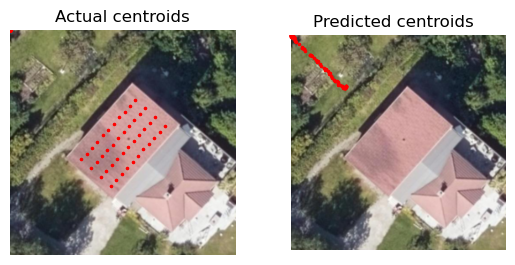

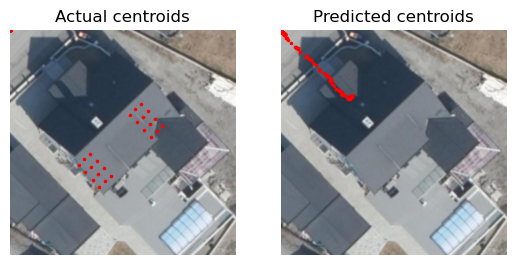

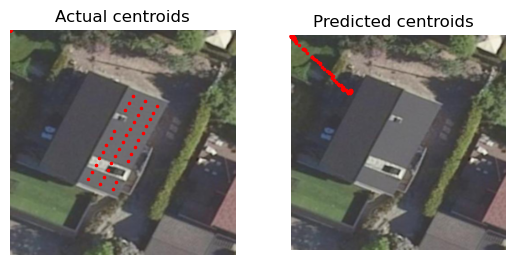

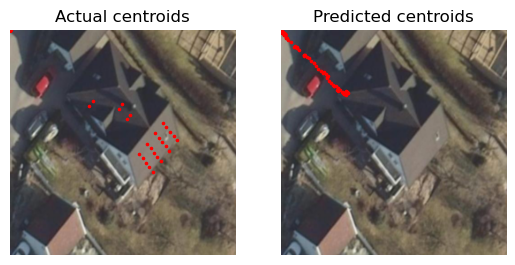

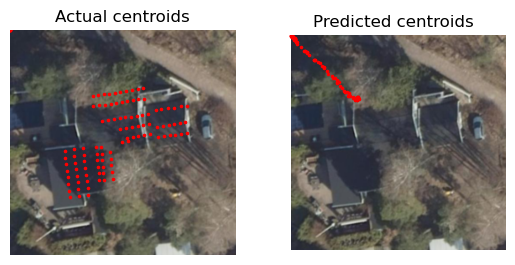

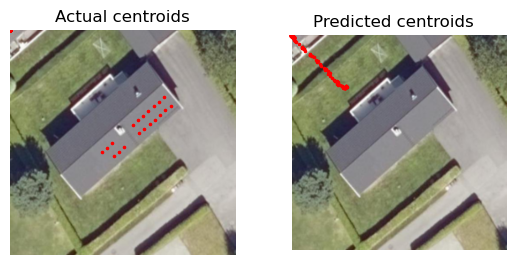

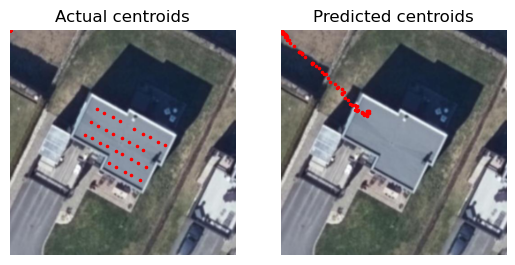

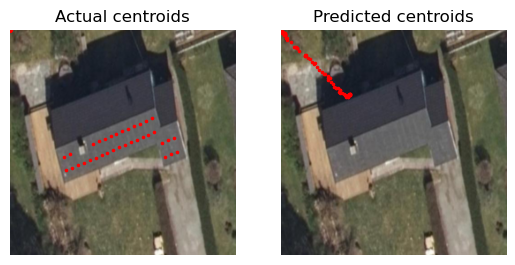

[tensor([[[ 6.0352e+01,  6.4651e+01],
          [ 6.0686e+01,  6.4489e+01],
          [ 6.0043e+01,  6.4602e+01],
          [ 6.0165e+01,  6.4030e+01],
          [ 6.1842e+01,  6.5070e+01],
          [ 6.1036e+01,  6.4945e+01],
          [ 6.1489e+01,  6.3839e+01],
          [ 6.1126e+01,  6.3911e+01],
          [ 6.1920e+01,  6.3324e+01],
          [ 6.2410e+01,  6.2904e+01],
          [ 6.2165e+01,  6.3059e+01],
          [ 6.2463e+01,  6.3184e+01],
          [ 6.2765e+01,  6.3400e+01],
          [ 6.2404e+01,  6.1356e+01],
          [ 6.3127e+01,  6.3400e+01],
          [ 6.1749e+01,  6.3073e+01],
          [ 6.2603e+01,  6.1570e+01],
          [ 6.0841e+01,  5.9901e+01],
          [ 6.1023e+01,  6.0427e+01],
          [ 6.0087e+01,  5.9290e+01],
          [ 5.8751e+01,  5.6845e+01],
          [ 5.9116e+01,  5.5516e+01],
          [ 5.8255e+01,  5.4493e+01],
          [ 5.6576e+01,  5.4785e+01],
          [ 5.5920e+01,  5.5553e+01],
          [ 5.4396e+01,  5.1351e+01],
          [ 

In [ ]:
test_model(network, test_loader, 8)